In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import json
import csv
from scipy import stats

import rpy2.rinterface

In [2]:
#github repo
mydir = "/Users/hanna/Desktop/MyBox/aa_DeRisi/mosquito/skeeters/"

In [3]:
# read in json file

mypath = mydir + "/data/darkmatter/"
infile = mypath + "virus.json"
with open(infile, 'r') as in_file:
    df_viruses = pd.read_json(in_file).T

In [4]:
with open(infile, 'r') as in_file:
    data_viruses = json.load(in_file)

In [5]:
# snippet for handling cdhit output from Multisegmented Virus Hunting notebook

from collections import defaultdict, namedtuple
Member = namedtuple('Member', ['contig', 'length', 'percent_id', 'percent_id_sign', 'sample', 'coverage'])

def parse_cdhit_row(row):
    if '*' in row:
        index, length, name, percent_id = row.split()
        percent_id_sign, percent_id = '0', 100
    else:
        index, length, name, _, percent_id = row.split()
    length = int(length.strip(',nt'))
    name = name.strip('>').strip('.')
    sample, contig = name.split('~')
    coverage = float(contig.split('_')[-1])
    
    if percent_id != 100:
        percent_id_sign, percent_id = percent_id.strip('%').split('/')
        percent_id = float(percent_id)
    return Member(contig=contig, sample=sample, length=length,
                  percent_id=percent_id, percent_id_sign=percent_id_sign, coverage=coverage)


clusters = defaultdict(list)
with open(mydir+'/data/500_contigs_cluster.clstr', 'r') as file:
    for line in file:
        if line.startswith('>Cluster'):
            cluster_id = line.split()[-1]
        else:
            member = parse_cdhit_row(line)
            if 'water' in member.sample.lower():
                continue
            clusters[cluster_id].append(member)

def get_representative(cluster):
    representative = [member for member in cluster if member.percent_id_sign == '0'][0]
    return representative

def print_cluster(cluster_id):
    cluster = clusters[cluster_id]
    representative = get_representative(cluster)
    samples = defaultdict(list)
    for member in cluster:
        samples[member.sample].append(str(member.length))
    lengths_list = ','.join(['+'.join(lengths) for lengths in samples.values()])
    
    print('Cluster: ', cluster_id)
    print('Rep contig: ', representative.sample, representative.contig)
    print('Rep Length: ', representative.length)
    print('N samples: ', len(samples))
    print('Contig Lengths: ', lengths_list)

contig_to_cluster = {member.contig: cluster_id for cluster_id in clusters for member in clusters[cluster_id]}


In [6]:
# HR
def get_samples(cluster):
    samples_list = [member.sample for member in clusters[cluster]]
    return samples_list

# Determine whether virus.json contains all relevant narna contigs

HR's pull of clusters that contain narna RdRp or Robin
Based on minimapping representative contigs from '500_contigs_cluster.clstr' to known narna sequences

Cluster 493
Cluster 509
Cluster 516
Cluster 6465
Cluster 10146
Cluster 18824
Cluster 20071
Cluster 20247
Cluster 20274
Cluster 24617
Cluster 25004

In [22]:
clusters_narnaRdRp = ['493',
'509',
'516',
'10146']

clusters_narnaRobin = ['6465',
'18824',
'20071',
'20247',
'20274',
'24617',
'25004']

In [23]:
l = []
for cluster in clusters_narnaRdRp + clusters_narnaRobin:
    l.append(get_samples(cluster))
flat_list = [item for sublist in l for item in sublist]
samples_narna = sorted(list(set(flat_list)))

In [24]:
# read in narna samples from previous cataloguing

infile='/Users/Hanna/Desktop/MyBox/aa_DeRisi/mosquito/november2019/narna_sample_names_n54n47.csv'
with open(infile, 'r') as in_file:
    samples_narna_n54n47 = sorted(list(csv.reader(in_file))[0])

In [25]:
# using dataframe below (from reanalysis 11/14/19), df_narna
samples_uptodate = sorted(list(df_narna['sample_trunc'].unique()))
samples_uptodate == samples_narna_n54n47

True

In [26]:
# compare samples from each method
samples_narna_500cluster = ['_'.join(s.split('_')[0:2]) for s in samples_narna]
print(set(samples_narna_500cluster) - set(samples_narna_n54n47)) 
print(set(samples_narna_n54n47) - set(samples_narna_500cluster))

set()
{'CMS002_028b', 'CMS002_028c', 'CMS002_047e', 'CMS001_009', 'CMS001_006', 'CMS002_036a', 'CMS002_025c', 'CMS002_040a', 'CMS001_water3_Qiagen_S26', 'CMS002_056a', 'CMS002_025e'}


Conclusion: virus.json is missing 10 samples that have narna contigs between 200-500nt.
So, for these analyses, will use previous pull of narna contigs based on minimapping

# Abundance correlation plot

Input files needed:
Manually curated list of contigs (>200nt) for narna_RdRp:'narnaRdRp_samplecontig.csv'
Manually curated list of contigs (>200nt) for narna_Robin: 'narnaRobin_samplecontig.csv'
Read counts for contigs: s3://czbiohub-mosquito/contig_quality_concat/contig_stats_all.tsv
IDSeq metadata: https://github.com/czbiohub/skeeters/tree/master/data/metadata/idseq_metadata.csv     

In [7]:
# read in csv to get sample and contig names for all narna contigs
mydir = "/Users/Hanna/Desktop/MyBox/aa_DeRisi/mosquito/november2019/"

In [8]:
infile = 'narnaRdRp_samplecontig.csv'
with open(mydir + infile, 'r') as in_file:
    df = pd.read_csv(in_file, header=None)
    df.columns = ['sample_trunc','contig_name']
    df['segment'] = 'rdrp'
    df_rdrp = df

In [9]:
infile = 'narnaRobin_samplecontig.csv'
with open(mydir + infile, 'r') as in_file:
    df = pd.read_csv(in_file, header=None)
    df.columns = ['sample_trunc','contig_name']
    df['segment'] = 'robin'
    df_robin = df

In [10]:
df_narna = pd.concat([df_rdrp, df_robin])
df_narna_nowater = df_narna[~df_narna.sample_trunc.str.contains("ater")]

In [11]:
A = list(df_narna_nowater[df_narna_nowater['segment']=='rdrp']['sample_trunc'].unique())
B = list(df_narna_nowater[df_narna_nowater['segment']=='robin']['sample_trunc'].unique())
C = list(df_narna_nowater['sample_trunc'].unique())
print('N samples with rdrp: ' + str(len(A)))
print('N samples with robin: ' + str(len(B)))
print('N samples with rdrp and/or robin: ' + str(len(C)))
print('N samples with both: ' + str(len(set(A)-(set(A) - set(B)))))
print('rdrp but no robin: ' + str((set(A) - set(B))))
print('robin but no rdrp: ' + str((set(B) - set(A))))

N samples with rdrp: 46
N samples with robin: 53
N samples with rdrp and/or robin: 56
N samples with both: 43
rdrp but no robin: {'CMS002_051a', 'CMS001_009', 'CMS002_025e'}
robin but no rdrp: {'CMS002_028b', 'CMS002_031a', 'CMS002_028c', 'CMS002_047e', 'CMS001_006', 'CMS002_038a', 'CMS002_036a', 'CMS002_025c', 'CMS002_040a', 'CMS002_056a'}


In [12]:
# read in Read counts for contigs: s3://czbiohub-mosquito/contig_quality_concat/contig_stats_all.tsv
mydir = "/Users/Hanna/Desktop/MyBox/aa_DeRisi/mosquito/november2019/"
infile = 'contig_stats_all.tsv'
with open(mydir + infile, 'r') as in_file:
    df_counts = pd.read_csv(in_file, header=0, delimiter='\t')

df_counts['sample_trunc'] = ['_'.join(x.split('_')[0:2]) for x in df_counts['sample'] ]

In [13]:
# read in IDSeq metadata: idseq_metadata.csv for denominator for rpM
mydir = "/Users/hanna/Desktop/MyBox/aa_DeRisi/mosquito/skeeters/"
infile = 'idseq_metadata.csv'
with open(mydir + 'data/metadata/' + infile, 'r') as in_file:
    idseq_metadata = pd.read_csv(in_file, header=0)

idseq_metadata['sample_trunc'] = ['_'.join(x.split('_')[0:2]) 
                                  for x in idseq_metadata['sample'] ]

In [14]:
# check that truncated sample names doesn't create duplicates
print(len(df_counts['sample_trunc'].unique()) == len(df_counts['sample'].unique()) )

True


In [15]:
# merge dataframes
df_summary = pd.merge(df_narna, df_counts, on=['sample_trunc','contig_name'])
df_summary = pd.merge(df_summary, idseq_metadata, on=['sample_trunc'])
df_summary['rpm'] = df_summary['read_count'] / df_summary['total_reads'] *1e6

In [16]:
df_summary.head()

,sample_trunc,contig_name,segment,sample_x,contig_length,read_count,sample_y,total_reads,nonhost_reads,total_ercc_reads,compression_ratio,water,input_conc,rpm
0,CMS001_009,NODE_19969_length_232_cov_0.741935,rdrp,CMS001_009_Ra_S13,232,2,CMS001_009_Ra_S13,62306790,813290,2678,2.28,False,23265.165049,0.032099
1,CMS001_004,NODE_1_length_3148_cov_123.031911,rdrp,CMS001_004_Ra_S2,3148,5568,CMS001_004_Ra_S2,35584846,46660,2586,1.18,False,13759.574633,156.471100
2,CMS001_004,NODE_17_length_847_cov_664.774026,robin,CMS001_004_Ra_S2,847,7771,CMS001_004_Ra_S2,35584846,46660,2586,1.18,False,13759.574633,218.379475
3,CMS001_002,NODE_7_length_3150_cov_193.138301,rdrp,CMS001_002_Ra_S1,3150,8757,CMS001_002_Ra_S1,31503742,369628,3080,1.25,False,10227.487662,277.966979
4,CMS001_002,NODE_113_length_849_cov_354.167098,robin,CMS001_002_Ra_S1,849,4052,CMS001_002_Ra_S1,31503742,369628,3080,1.25,False,10227.487662,128.619641


In [17]:
df = df_summary.groupby(['sample_trunc','segment'], as_index=False).agg(
    {'contig_length': 'max', 'rpm': 'sum'} )
df.head()

,sample_trunc,segment,contig_length,rpm
0,CMS001_002,rdrp,3150,277.966979
1,CMS001_002,robin,849,128.619641
2,CMS001_004,rdrp,3148,156.471100
3,CMS001_004,robin,847,218.379475
4,CMS001_006,robin,344,0.094424


In [18]:
df_out = df.pivot(index='sample_trunc', columns='segment', values='rpm')
df_out.head()

segment,rdrp,robin
sample_trunc,,
CMS001_002,277.966979,128.619641
CMS001_004,156.471100,218.379475
CMS001_006,NaN,0.094424
CMS001_009,0.032099,NaN
CMS001_011,183.880761,227.316822


In [19]:
mydata = df_out.fillna(0)
X = mydata['rdrp']
Y = mydata['robin']

In [20]:
slope, intercept, r_value, p_value, std_err = stats.linregress(X, Y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("R-squared: %f" % r_value**2)

slope: 0.864032    intercept: 4.904146
R-squared: 0.878726


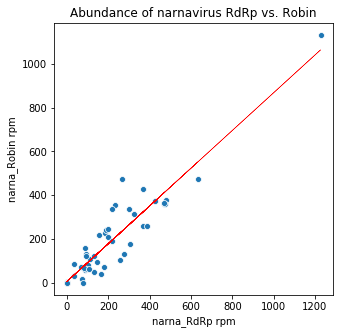

In [21]:
f1, ax = plt.subplots(1,1, figsize=(5,5))
ax = sns.scatterplot(x='rdrp', y='robin', data = mydata)
plt.plot(X, intercept + slope*X, 'r', linewidth=0.5)

plt.xlabel('narna_RdRp rpm');
plt.ylabel('narna_Robin rpm');
plt.title('Abundance of narnavirus RdRp vs. Robin');

outdir = "/Users/Hanna/Desktop/MyBox/aa_DeRisi/mosquito/november2019/"
plt.savefig(outdir+"fig_narna_Robin_vs_RdRp_rpm_v2.pdf",bbox_inches='tight')

plt.show()

# Tanglegram narna RdRp vs. Robin

Input files needed:
    RAxML_bipartitionsBranchLabels.T19_narnaRdRp_rooted.newick
    RAxML_bipartitionsBranchLabels.T20_narnaRobin_rooted.newick

In [27]:
%load_ext rpy2.ipython

In [29]:
%%R

required_libraries <- c( "ape",  "ggplot2", "ggtree",  "phylogram","dendextend")
missing_libraries <- required_libraries[!(required_libraries %in% installed.packages())]
if (length(missing_libraries) > 0) sapply(missing_libraries, install.packages)
invisible(lapply(required_libraries, library, character.only=TRUE))

In [30]:
%%R

mydir = "/Users/Hanna/Desktop/MyBox/aa_DeRisi/mosquito/november2019/"

infile="RAxML_bipartitionsBranchLabels.T19_narnaRdRp_rooted.newick"
mltree <- ape::read.tree(paste0(mydir, infile))
mltree_RdRp <- mltree

infile="RAxML_bipartitionsBranchLabels.T20_narnaRobin_rooted.newick"
mltree <- ape::read.tree(paste0(mydir, infile))
mltree_Robin<- mltree

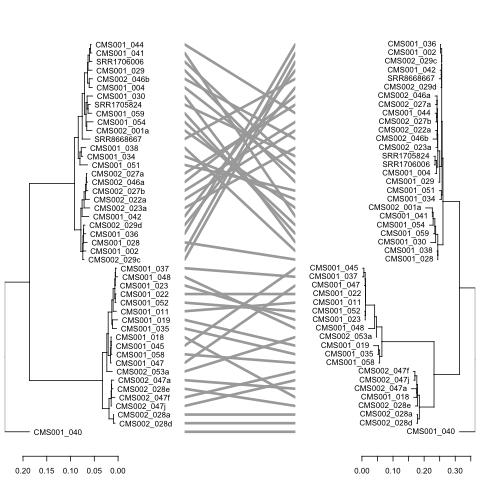

In [31]:
%%R

dnd1 <- phylogram::as.dendrogram.phylo(mltree_Robin)
dnd2 <- phylogram::as.dendrogram.phylo(mltree_RdRp)

## rearrange in ladderized fashion
dnd1 <- ladder(dnd1)
dnd2 <- ladder(dnd2)

## plot the tanglegram
dndlist <- dendextend::dendlist(dnd2, dnd1)
dendextend::tanglegram(dndlist, fast = TRUE, margin_inner=7)
